# 1 - Imports + Preparation

In [1]:
import torch
import numpy as np
import spyrit.misc.walsh_hadamard as wh

from matplotlib import pyplot as plt

from spyrit.learning.model_Had_DCAN import *
from spyrit.misc.disp import torch2numpy, imagesc, plot
# from spyrit.misc.statistics import Cov2Var
# from spyrit.learning.model_Had_DCAN import Cov2Var
from spyrit.learning.nets import *
from spyrit.misc.metrics import psnr_

# from spas import read_metadata, reconstruction_hadamard
# from spas import ReconstructionParameters, setup_reconstruction, load_noise, reconstruct
# from spas.noise import noiseClass
# from spas.visualization import *
#from siemens_star_analysis import *


In [2]:
plt.rcParams['text.usetex'] = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Torch device: {device}')

Torch device: cuda:0


In [3]:
#%% Spectral binning (and checking a few things)
def subsample(spectral_data, CR):
    # If only one wavelength is considered
    if spectral_data.ndim == 1:
        torch_img = np.zeros((2*CR))
        
        pos = spectral_data[0::2][:CR]
        neg = spectral_data[1::2][:CR]
        
        torch_img[0::2] = pos
        torch_img[1::2] = neg
    
    # If spectral_data contains  all wavelengths
    if spectral_data.ndim == 2:
        
        torch_img = np.zeros((2*CR, spectral_data.shape[1]))
        
        pos = spectral_data[0::2][:CR,:]
        neg = spectral_data[1::2][:CR,:]
        
        torch_img[0::2,:] = pos
        torch_img[1::2,:] = neg
    
    return torch_img


def meas2img_from_ind(meas, ind, N):
    """Return image from measurement vector

    Args:
        meas (ndarray): Measurement vector. Must be 1-D.
        ind (ndarray):  Pattern indices. Must be 1-D.
        N (int):        Returned image will be N x N

    Returns:
        Img (ndarray): Measurement image. 2-D array
    """
    y = np.pad(meas, (0, N**2-len(meas)))
    Perm = permutation_from_ind(ind+1)
    Img = (Perm @ y).reshape((N, N))
    return Img

def completion(meas, M, Perm, Cov, Mean):
    
    nx, ny = Mean.shape
    
    # reorder measurements and statistics
    y     = Perm @ (meas.ravel())
    mu    = Perm @ (Mean.ravel())
    Sigma = Perm @ Cov @ Perm.T
    
    # extract blocks corresponding to acquired and missing measurements 
    mu1 = mu[:M]            # mean of acquired measurements
    mu2 = mu[M:]            # mean of missing measurements
    Sigma1  = Sigma[:M,:M]  # covariance of acquired measurements
    Sigma21 = Sigma[M:,:M]  # covariance of missing measurements

    m = y[:M];
    
    # Bayesian denoised completion
    #y1 = mu1 + W1 @ ( m - mu1)
    y1 = m
    #y2 = mu2 + Sigma21 @ np.linalg.lstsq(Sigma1,(y1 - mu1), rcond=None)[0]
    y2 = Sigma21 @ np.linalg.lstsq(Sigma1, y1, rcond=None)[0]
    #y2 = Sigma21 @ np.linalg.inv(Sigma1) @ y1
    y[:M] = y1
    y[M:] = y2
    
    # reorder output
    y = Perm.T @ y
    y = np.reshape(y,(nx, ny))
    
    return y

def unsplit(raw):
    had = raw[0::2] - raw[1::2]
    return had



# 2 - Parameters and Neural Network

In [4]:
#%% Load reconstrcution network
img_size = 64
net_arch = 0 # Network variant
CR = 2048;


# Intensity distribution
N0 = 10
sig = 0

In [5]:
H = wh.walsh2_matrix(img_size) / img_size
Mean = np.load('./data/Average_64x64.npy')/img_size
Cov  = np.load('./data/Cov_64x64.npy')/img_size**2

In [6]:
Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];

In [7]:
#- Training parameters
num_epochs = 30
lr = 1e-3 
step_size = 10
gamma = 0.5
batch_size = 512
reg = 1e-7

suffix = '_N0_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(
           img_size, CR, num_epochs, lr, step_size,
           gamma, batch_size, reg)


denoi = DConvNet();
# denoi_6 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
model = DenoiCompNet(img_size, CR, Mean, Cov, net_arch, N0, sig, H, denoi=denoi);
# model = DenoiCompNet(img_size, CR, Mean, Cov, net_arch, N0, sig, H, Cov2Var(Cov))
model.to(device)
# load_net(title, model);
model.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements


DenoiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5

# 3 - Experimental Star Sector

## 3.1 - Loading data and visualising

In [8]:
f = np.load('./data/zoom_x1_starsector/zoom_x1_had_reco.npz')
raw = np.load('./data/zoom_x1_starsector/zoom_x1_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)

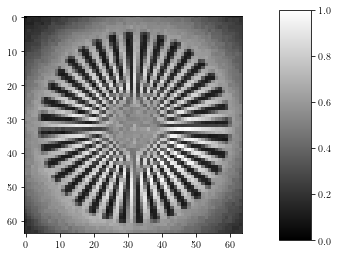

In [9]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

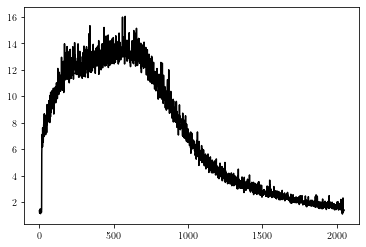

In [10]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [11]:
index = 300;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]


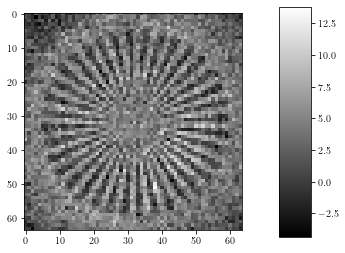

In [12]:
imagesc(F_bin_GT)

In [13]:
m_raw_data = raw_data[:2*CR];

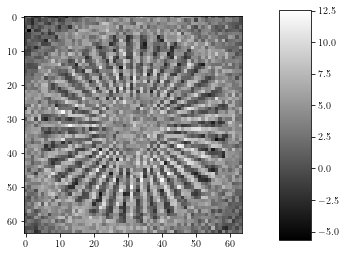

psnr = 23.3837514086353


In [14]:
# WHY NOT THE SAME!? - Bref, pas important, surement lié aux meta données... [les indices ne doivent pas être dans l'ordre des longeurs d'onde] + Image Flippée
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

img_temp = pinv_test;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 3.2 - Pinv reconstruction 

In [15]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

### 3.2.1 - Inverse walsh transform

psnr = 22.79636241110427


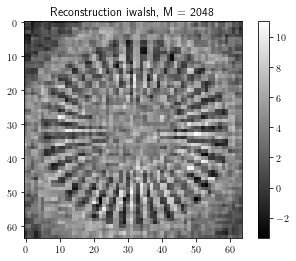

In [16]:
# Pinv from iwht
m_raw = raw_unsplit[:CR];
rec_had = np.zeros((img_size**2,));
rec_had[:CR] = m_raw;
rec_had = np.dot(Perm.T, rec_had);
rec_had = np.reshape(rec_had, (img_size,img_size));
rec_had = wh.iwalsh2(rec_had);
plt.figure()
plt.imshow(rec_had, cmap='gray')
plt.colorbar()
plt.title(f"Reconstruction iwalsh, M = {CR}")

img_temp = rec_had;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

### 3.2.2 - Moore penrose pseudo-inverse (via matrix product)

psnr = 22.79636241110427


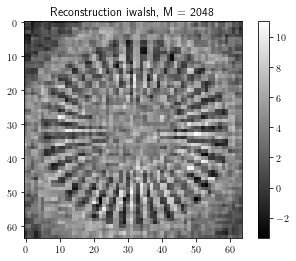

In [17]:
# Pinv matrix product
m_raw = raw_unsplit[:CR];
rec_had = np.zeros((img_size**2,));
rec_had[:CR] = m_raw;
rec_had = np.dot(np.transpose(H_k), rec_had);
rec_had = (1/img_size**2)*np.reshape(rec_had, (img_size, img_size));

plt.figure()
plt.imshow(rec_had, cmap='gray')
plt.colorbar()
plt.title(f"Reconstruction iwalsh, M = {CR}")

img_temp = rec_had;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

### 3.2.3 - Pseudo inverse implemented in Neural network

psnr = 22.796362332434345


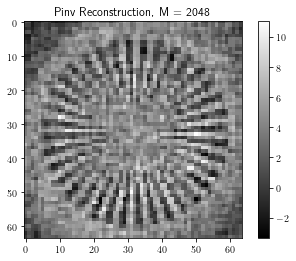

In [18]:
#%% PINV recon
x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*model.N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 3.3 - Completion

psnr = 17.691550793316843


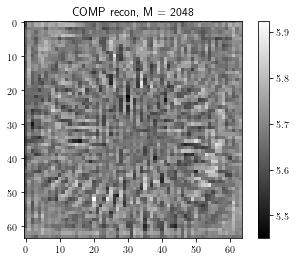

In [19]:
#%% COMP recon
model.N0 = recon_pinv.max()
 
result = model.forward_reconstruct_comp(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * model.N0/2
result = torch2numpy(result.view(img_size,img_size))

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'COMP recon, M = {CR}')


img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 3.4 - MMSE

psnr = 22.172103124504464


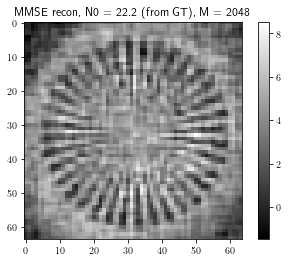

In [20]:
#%% MMSE recon with 2*N0
model.N0 = 2*recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * recon_pinv.max()
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')


img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

psnr = 19.490187523192667


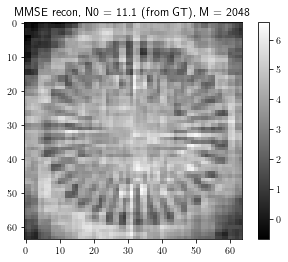

In [21]:
#%% MMSE recon with true N0 
model.N0 = recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * recon_pinv.max()/2
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')


img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

# 4 - Experimental tomato slice

## 4.1 - Loading data and visualising

In [22]:
# f = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_had_reco.npz')
# raw = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_spectraldata.npz')

f = np.load('./data/tomato_slice/tomato_slice_2_zoomx2_had_reco.npz')
raw = np.load('./data/tomato_slice/tomato_slice_2_zoomx2_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)

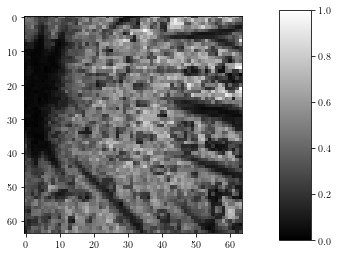

In [23]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

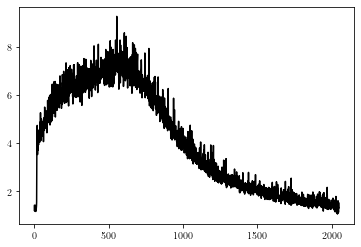

In [24]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [25]:
index = 1000;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]


In [26]:
m_raw_data = raw_data[:2*CR];

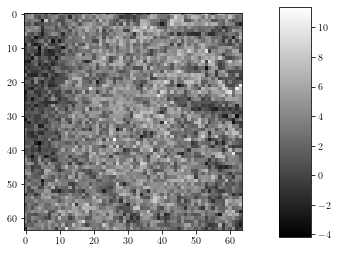

In [27]:
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

## 4.2 - Pinv reconstruction 

In [28]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

psnr = 20.693706606082834


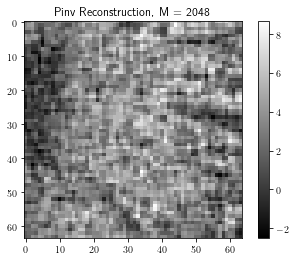

In [29]:
#%% PINV recon
x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*model.N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()


img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 4.3 - MMSE

psnr = 20.593407332139346


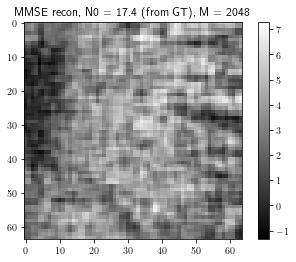

In [30]:
#%% MMSE recon with 2*N0
model.N0 = 2*recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * recon_pinv.max()
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')

img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

psnr = 19.573821894576078


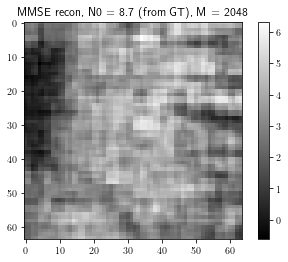

In [31]:
#%% MMSE recon with true N0 
model.N0 = recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * recon_pinv.max()/2
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')

img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

# 5 - Experimental Cat

## 5.1 - Loading data and visualising

In [32]:
# f = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_had_reco.npz')
# raw = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_spectraldata.npz')

f = np.load('./data/cat/Cat_whiteLamp_had_reco.npz')
raw = np.load('./data/cat/Cat_whiteLamp_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)

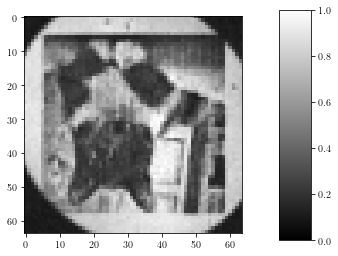

In [33]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

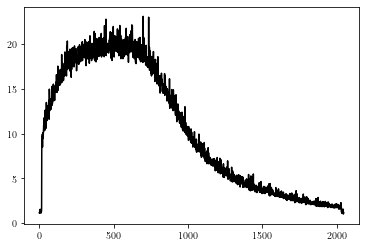

In [34]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [35]:
index = 1500;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]


In [36]:
m_raw_data = raw_data[:2*CR];

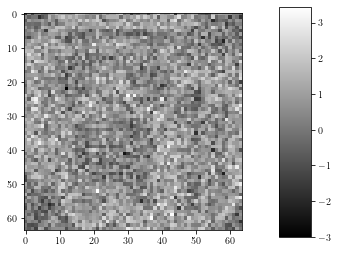

In [37]:
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

## 6.2 - Pinv reconstruction 

In [38]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

psnr = 18.9572229010445


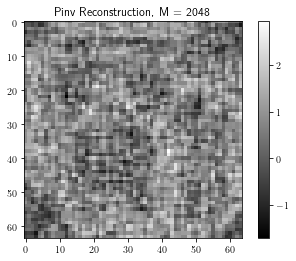

In [39]:
#%% PINV recon
x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*model.N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 6.3 - MMSE

psnr = 20.70162521456049


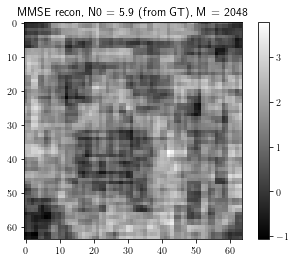

In [40]:
#%% MMSE recon with 2*N0
model.N0 = 2*recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * model.N0;
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')

img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

psnr = 21.279936805087768


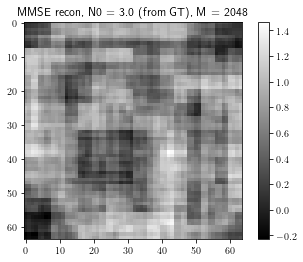

In [41]:
#%% MMSE recon with true N0 
model.N0 = recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * model.N0/2
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')

img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

# 6 - Experimental Horse

## 6.1 - Loading data and visualising

In [42]:
# f = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_had_reco.npz')
# raw = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_spectraldata.npz')

f = np.load('./data/horse/Horse_WhiteLamp_had_reco.npz')
raw = np.load('./data/horse/Horse_WhiteLamp_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)

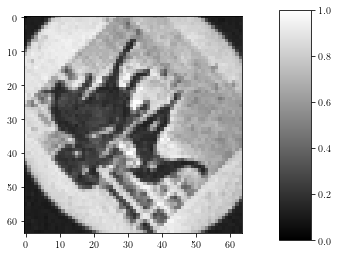

In [43]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

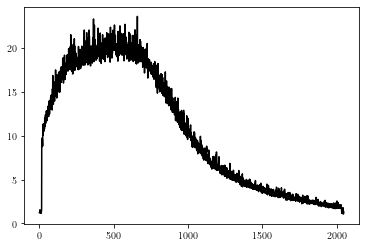

In [44]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [45]:
index = 1000;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]


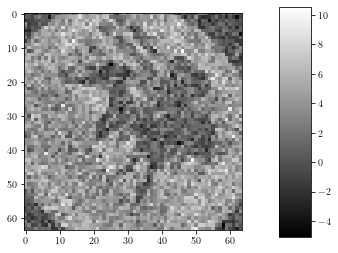

In [46]:
imagesc(F_bin_GT)

In [47]:
m_raw_data = raw_data[:2*CR];

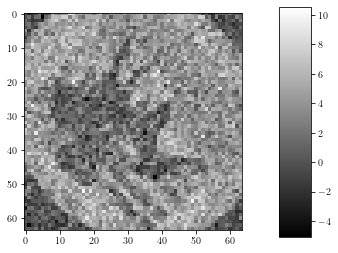

In [48]:
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

## 6.2 - Pinv reconstruction 

In [49]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

psnr = 21.530850766316565


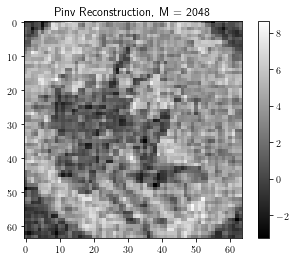

In [50]:
#%% PINV recon
x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*model.N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 6.3 - MMSE

psnr = 22.92985734966768


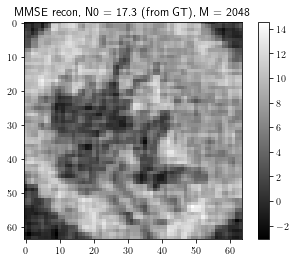

In [51]:
#%% MMSE recon with 2*N0
model.N0 = 2*recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * model.N0;
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')

img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

psnr = 23.245157332442407


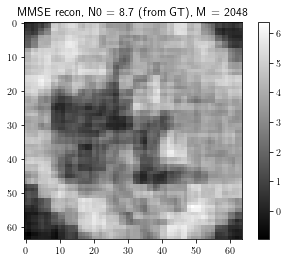

In [52]:
#%% MMSE recon with true N0 
model.N0 = recon_pinv.max()
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * model.N0/2
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')

img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

# 7 - Experimental Star Sector

## 7.1 - Loading data and visualising

In [53]:
# f = np.load('./data/zoom_x1_starsector/zoom_x1_had_reco.npz')
f = cv2.imread("./data/star_sector/starsector.png")
f = f.astype(np.float)
f = cv2.resize(f, (img_size, img_size), interpolation = cv2.INTER_AREA)
f = f[:,:,0]+f[:,:,1]+f[:,:,2];
f = (f-np.amin(f))/(np.amax(f)-np.amin(f))

img_GT_all_Channels = f;

N0_simu = 10;
f = N0_simu*np.reshape(f, (img_size**2,))

H_plus = np.zeros(H_k.shape);
H_minus = np.zeros(H_k.shape);
H_plus[H_k>0] = H_k[H_k>0];
H_minus[H_k<0] = (-1)*H_k[H_k<0];

m_plus = np.dot(H_plus,f);
m_minus = np.dot(H_minus,f);

m_plus = np.random.poisson(m_plus);
m_minus = np.random.poisson(m_minus);
raw_data = np.zeros((2*img_size**2,));
raw_data[0::2] = m_plus;
raw_data[1::2] = m_minus;

# raw = np.load('./data/zoom_x1_starsector/zoom_x1_spectraldata.npz')

# # for key in f:
# #     print(key)

# # for key in raw:
# #     print(key)    

# spectral_data = f['arr_0']
# raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)

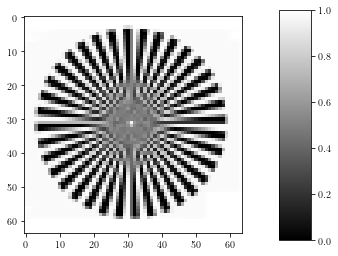

In [54]:
imagesc(img_GT_all_Channels)

In [55]:
# mean_imgs = np.amax(spectral_data, axis = (0,1))
# plot(range(mean_imgs.shape[0]),mean_imgs)

In [56]:
index = 300;
# F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data;
# imagesc(F_bin_GT)
img_size = img_size


In [57]:
m_raw_data = raw_data[:2*CR];

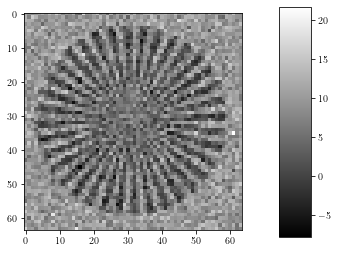

psnr = 16.004624228333945


In [58]:
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

img_temp = pinv_test;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 7.2 - Pinv reconstruction 

In [59]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

psnr = 16.409390986015843
psnr = 11.795960798569805


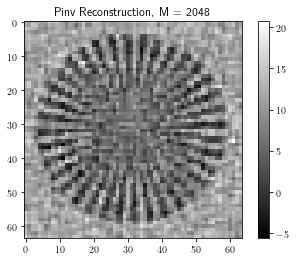

In [60]:
#%% PINV recon
x_inv = model.forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*N0_simu/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp-np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

img_temp = result/N0_simu;
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 7.3 - MMSE

psnr = 16.94670299985416
psnr = 18.981499162714698


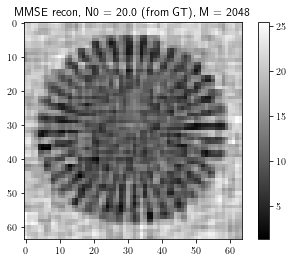

In [61]:
#%% MMSE recon with 2*N0
model.N0 = 2*N0_simu;
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * model.N0
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')


img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

img_temp = result/N0_simu/2;
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

psnr = 15.380453780948823
psnr = 17.88733439726418


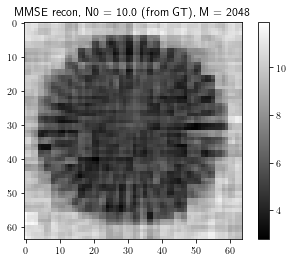

In [62]:
#%% MMSE recon with true N0 
model.N0 = N0_simu
result = model.forward_reconstruct_mmse(
    m, 1, 1, img_size, img_size, 
)

result = (result+1) * model.N0/2
result = result.cpu().detach().numpy().squeeze()

plt.figure()
plt.imshow(result, cmap='gray')
plt.colorbar()
plt.title(f'MMSE recon, N0 = {model.N0:.1f} (from GT), M = {CR}')


img_temp = result;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

img_temp = result/N0_simu;
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))